# Classification Problem : Credit Card Offer

### Importing the librairies

In [1]:
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import seaborn as sns
from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from scipy.stats import chi2_contingency
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

## 1. Cleaning the CSV file to be uploaded on MySQLworkbench

In [2]:
df = pd.read_csv('creditcardmarketing.csv') 
df.head()

,Customer Number,Offer Accepted,Reward,Mailer Type,Income Level,# Bank Accounts Open,Overdraft Protection,Credit Rating,# Credit Cards Held,# Homes Owned,Household Size,Own Your Home,Average Balance,Q1 Balance,Q2 Balance,Q3 Balance,Q4 Balance
0,1,No,Air Miles,Letter,High,1,No,High,2,1,4,No,1160.75,1669.0,877.0,1095.0,1002.0
1,2,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,147.25,39.0,106.0,78.0,366.0
2,3,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,276.50,367.0,352.0,145.0,242.0
3,4,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,1219.00,1578.0,1760.0,1119.0,419.0
4,5,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,1211.00,2140.0,1357.0,982.0,365.0


**We will clean the headers only.**

In [3]:
def renaming(df):
    #removing special characters & following the snake case
    
    df.columns = df.columns.str.replace(' ', '_').str.lower()
    df.columns = df.columns.str.replace('#_','')
    return df.info()

In [4]:
renaming(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18000 entries, 0 to 17999
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_number       18000 non-null  int64  
 1   offer_accepted        18000 non-null  object 
 2   reward                18000 non-null  object 
 3   mailer_type           18000 non-null  object 
 4   income_level          18000 non-null  object 
 5   bank_accounts_open    18000 non-null  int64  
 6   overdraft_protection  18000 non-null  object 
 7   credit_rating         18000 non-null  object 
 8   credit_cards_held     18000 non-null  int64  
 9   homes_owned           18000 non-null  int64  
 10  household_size        18000 non-null  int64  
 11  own_your_home         18000 non-null  object 
 12  average_balance       17976 non-null  float64
 13  q1_balance            17976 non-null  float64
 14  q2_balance            17976 non-null  float64
 15  q3_balance         

There are 24 NAN values in the last 5 columns. The 24 rows with the non values will not be uploaded on MySQLWorkbench.

In [5]:
# saving the dataframe into CVS file for SQL 

df.to_csv('credit_card_data.csv')

## 2. Cleaning and EDA 

In [6]:
# customer_number are unique values so we pass this variable as the index
df = df.set_index('customer_number')

In [7]:
df = df.drop_duplicates()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18000 entries, 1 to 18000
Data columns (total 16 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   offer_accepted        18000 non-null  object 
 1   reward                18000 non-null  object 
 2   mailer_type           18000 non-null  object 
 3   income_level          18000 non-null  object 
 4   bank_accounts_open    18000 non-null  int64  
 5   overdraft_protection  18000 non-null  object 
 6   credit_rating         18000 non-null  object 
 7   credit_cards_held     18000 non-null  int64  
 8   homes_owned           18000 non-null  int64  
 9   household_size        18000 non-null  int64  
 10  own_your_home         18000 non-null  object 
 11  average_balance       17976 non-null  float64
 12  q1_balance            17976 non-null  float64
 13  q2_balance            17976 non-null  float64
 14  q3_balance            17976 non-null  float64
 15  q4_balance         

### 2.1 - Starting with categorical data

In [91]:
def categorical_information (df):
    for col in df.select_dtypes('object'):
        print (df_cat[col].nunique(), '\n')
        print(df_cat[col].value_counts(), '\n')


In [92]:
# get information on categorical data

categorical_information(df)

2 

No     16955
Yes     1021
Name: offer_accepted, dtype: int64 

3 

Air Miles    6047
Cash Back    5995
Points       5934
Name: reward, dtype: int64 

2 

Postcard    9134
Letter      8842
Name: mailer_type, dtype: int64 

3 

Medium    9002
High      4519
Low       4455
Name: income_level, dtype: int64 

2 

No     15300
Yes     2676
Name: overdraft_protection, dtype: int64 

3 

High      6064
Medium    5964
Low       5948
Name: credit_rating, dtype: int64 

2 

Yes    11636
No      6340
Name: own_your_home, dtype: int64 



Create visuals for all categorical colums. We can see that the target variable 'offer_accepted' is highly imbalanced.

In [158]:
def count_plot_cat(df):
    for col in df.select_dtypes('object'):
        sns.countplot(df[col])
        plt.show()

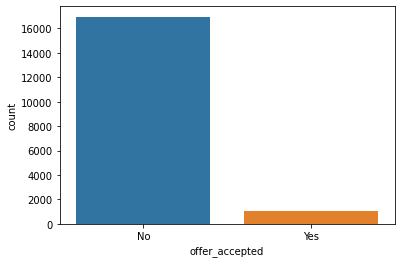

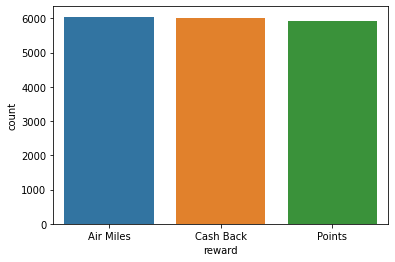

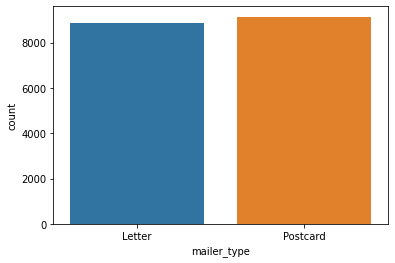

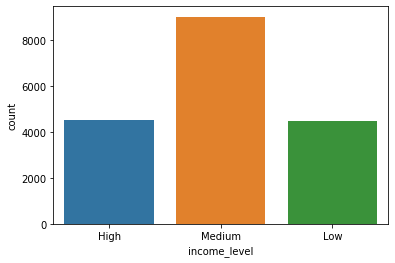

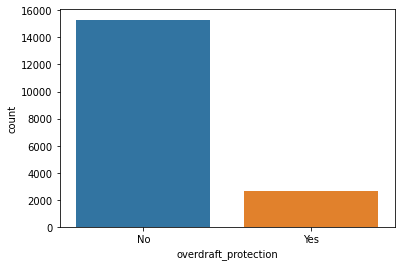

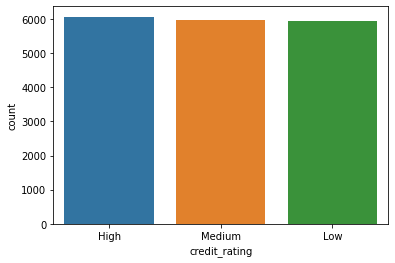

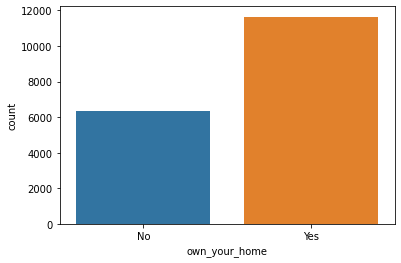

In [159]:
count_plot_cat(df)

### 2.2  Then numerical variables

**Dealing with NAN values**

In [15]:
df.isna().sum()

offer_accepted          0
reward                  0
mailer_type             0
income_level            0
bank_accounts_open      0
overdraft_protection    0
credit_rating           0
credit_cards_held       0
homes_owned             0
household_size          0
own_your_home           0
average_balance         0
q1_balance              0
q2_balance              0
q3_balance              0
q4_balance              0
dtype: int64

In [16]:
# checking the rows that are null 
df[df['q1_balance'].isna()==True] 

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance


In [8]:
# since there are only 24 rows with NAN values in the whole dataframe i.e 0,13% of the data, I will drop them.

df = df.dropna()
df = df.reset_index(drop=True)


**Exploring data**

In [17]:
df.describe()

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
count,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000,17976.000000
mean,1.255730,1.903427,1.203549,3.499110,6805.243096,50.467403,719.544561,162.105789,42.288029
std,0.472405,0.797086,0.427446,1.114476,3078.587261,20.383331,316.807442,64.163800,16.308323
min,1.000000,1.000000,1.000000,1.000000,127.776656,0.000000,0.000000,0.000000,0.000000
25%,1.000000,1.000000,1.000000,3.000000,5204.408502,35.507294,490.937010,119.125136,30.797006
50%,1.000000,2.000000,1.000000,3.000000,7209.703858,50.107051,746.498518,157.270555,42.567578
75%,1.000000,2.000000,1.000000,4.000000,8629.489065,70.485743,957.225683,212.432980,55.366270
max,3.000000,4.000000,3.000000,9.000000,35697.413862,105.978978,2320.209838,411.182054,100.157675


**Create a function to plot graphs of the continuous and discrete variables**

In [156]:
def numerical_plotting(df):
    decimaux = df.select_dtypes('float64')
    entiers = df.select_dtypes('int64')
    
    for col in decimaux:
        sns.distplot(continuous[col])
        plt.show()
        
    for col in entiers:
        sns.countplot(discrete[col])
        plt.show()

In [157]:
numerical_plotting(df)

KeyError: 'average_balance'

Correlation analysis

Covariance visualization :
we are only working on continuous variables since the discrete variables are featured as categorical variables.

In [163]:
#checking distribution of variables

def distribution_distplot(df):
    for col in df.select_dtypes('float64'):
        sns.distplot(df[col])
        # save the figure
        # plt.savefig('covariance_account_balance.png', dpi=100, bbox_inches='tight')
        plt.show()
    

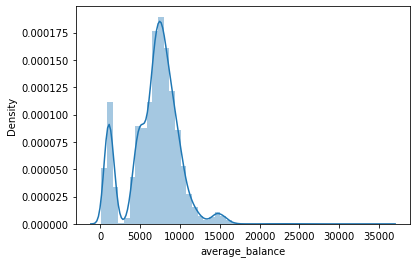

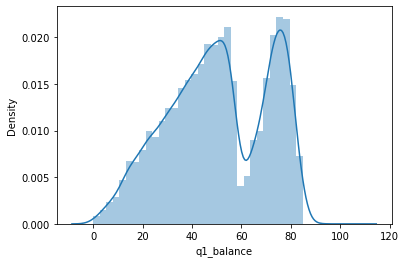

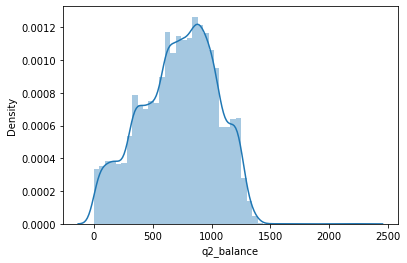

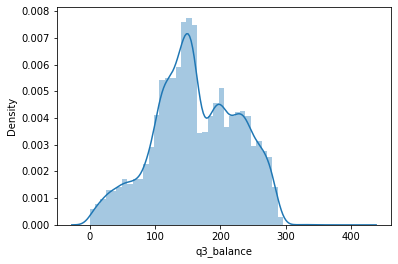

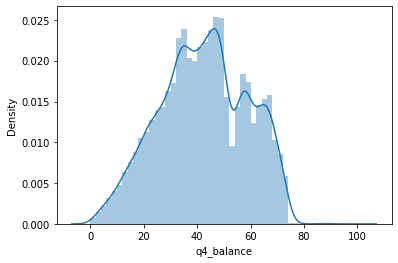

In [164]:
distribution_distplot(df)

In [146]:
def corr_matrix(df):
    corr_matrix=df.corr(method='pearson')
    fig, ax = plt.subplots(figsize=(10, 8))
    ax = sns.heatmap(corr_matrix, annot=True)
    plt.show()
    



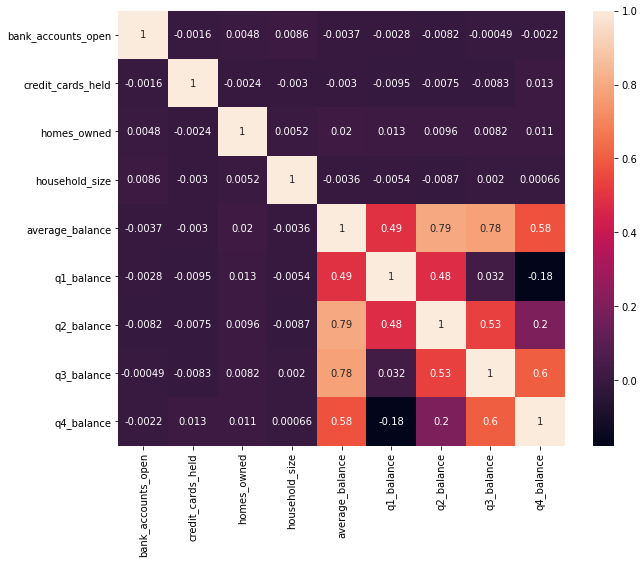

In [147]:
corr_matrix(df)

**Checking on outliers**

In [136]:
def vizualizing_outliers(df):
    for col in df._get_numeric_data():
            sns.boxplot(df_num[col])
            plt.show()
    

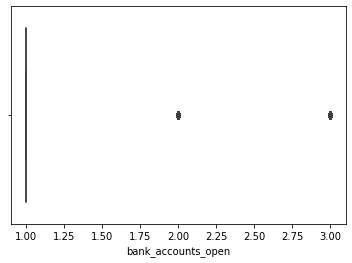

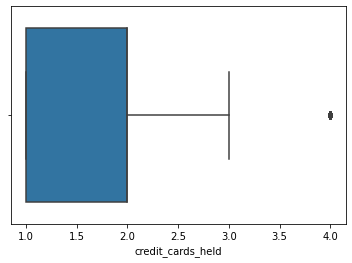

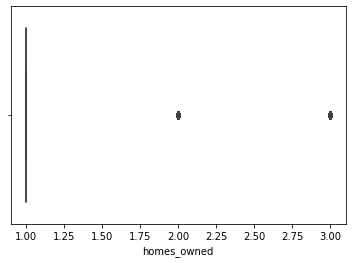

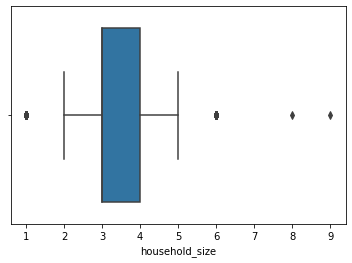

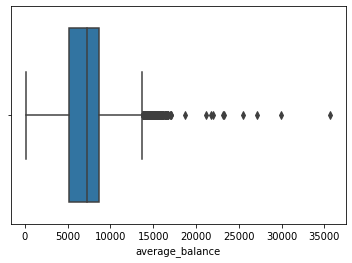

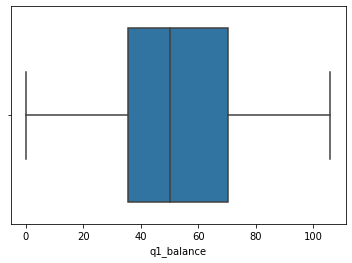

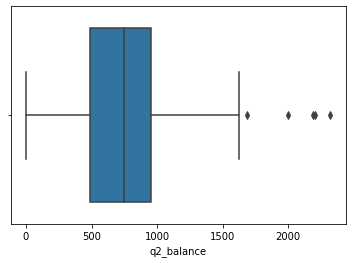

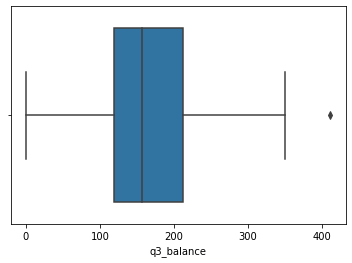

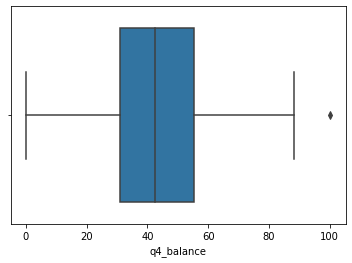

In [137]:
vizualizing_outliers(df)

**The outliers should not have relevant impact on our analysis. we will not remove them.**

## 2.3 - Exploration of the target variable : "accepted_offer"

We have already seen that the target variable is higly imbalanced. We will need to deal with this issue.
First, we will explore colinearity between variables.

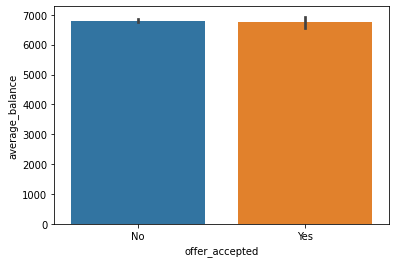

In [23]:
# average_balance vs offer_accepted

plt.figure(figsize=(6,4))
sns.barplot(data=df, y="average_balance", x="offer_accepted")
plt.show()

In [24]:
# Did the customers with the highest average balance accept the offer?

df.nlargest(20,columns="average_balance")[["average_balance","offer_accepted","mailer_type","income_level","own_your_home", "credit_rating","bank_accounts_open","credit_cards_held"]]

,average_balance,offer_accepted,mailer_type,income_level,own_your_home,credit_rating,bank_accounts_open,credit_cards_held
2295,35697.413862,No,Letter,High,No,Medium,1,2
12619,29947.633130,No,Letter,High,No,High,1,3
8875,27153.780075,No,Letter,Medium,Yes,Medium,1,2
10563,25471.493658,No,Letter,Medium,Yes,High,3,1
13984,23270.381725,No,Letter,Medium,Yes,Medium,1,1
10462,23175.523470,No,Letter,Medium,Yes,High,1,1
2654,22004.136073,No,Letter,Medium,No,Low,1,2
15238,21801.542158,No,Letter,Medium,No,High,1,2
15587,21193.444493,No,Postcard,High,Yes,Low,1,1
8765,18777.223560,No,Postcard,Medium,No,High,1,1


In [25]:
# Same question but with the customers with the lowest average balance?

df.nsmallest(20,columns="average_balance")[["average_balance","offer_accepted","mailer_type","income_level","own_your_home", "credit_rating","bank_accounts_open","credit_cards_held"]]

,average_balance,offer_accepted,mailer_type,income_level,own_your_home,credit_rating,bank_accounts_open,credit_cards_held
5703,127.776656,No,Postcard,Medium,Yes,Medium,2,1
2791,155.831074,No,Letter,Medium,Yes,Low,2,3
13301,178.446667,No,Letter,High,Yes,Medium,1,3
11262,184.215607,No,Postcard,Medium,No,High,1,1
5143,214.716127,No,Postcard,Medium,No,High,1,3
12892,227.838862,No,Letter,High,Yes,Medium,1,1
13142,230.894039,No,Postcard,Medium,Yes,Low,1,2
4220,232.936342,Yes,Postcard,High,Yes,Low,1,3
6699,234.983037,No,Letter,Low,Yes,Low,1,1
4335,246.317502,No,Postcard,Medium,No,Low,2,2


In [108]:
def count_plot_hue_target(df,columns=[], target = ''):
    for col in columns: 
        plt.figure(figsize=(6,4))
        sns.countplot(x = col, hue = target, data = df)
    plt.show()   

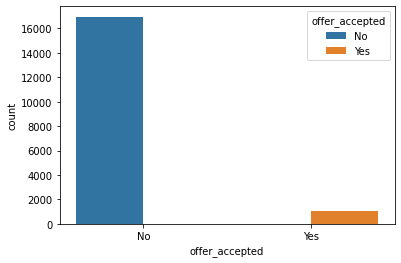

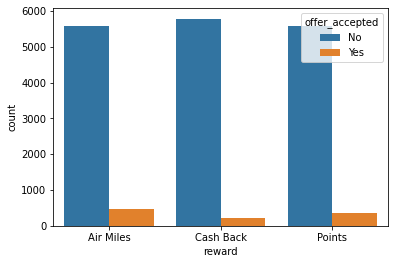

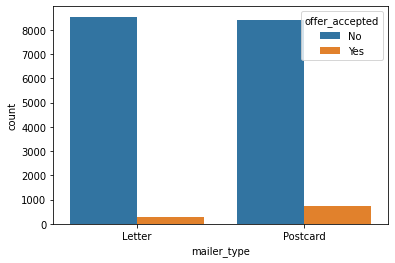

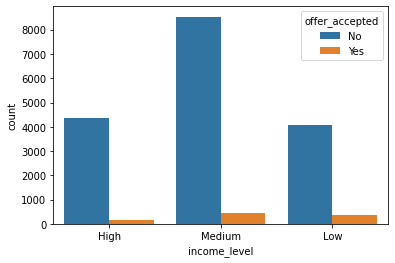

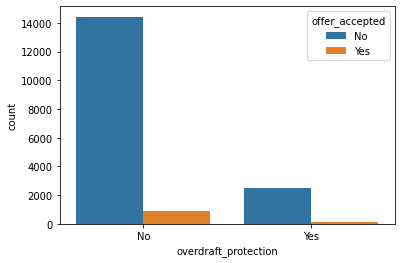

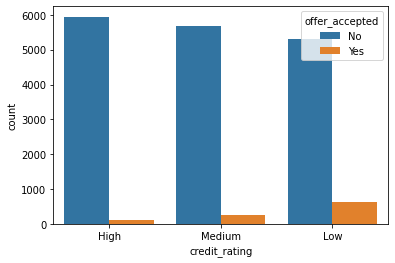

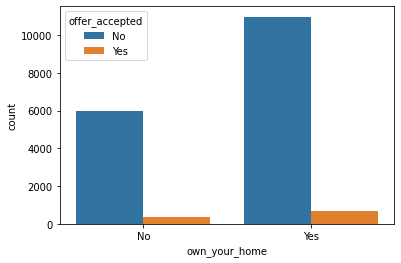

In [110]:
count_plot_hue_target(df, columns= df.select_dtypes('object'), target ='offer_accepted')

Checking correlation between variables

The p_value is used for hypothesis testing and it can be used to measure dependency between two variables.

A low p_value means that there is significant relationship between two variables.

A reasonable threshold for p_value is 0.05, and it's related to a confidence interval of 95%. 

For now: a p_value below 0.05 means that there is a considerable correlation between two variables, and it is likely that one of them can be dropped without decreasing the metrics of the model.

**correlation between 'offer_accepted' and 'income_level'**

In [ ]:
# contingency table
data_crosstab = pd.crosstab(df_cat['offer_accepted'], df_cat['income_level'], margins = False)
data_crosstab

In [ ]:
chi2_contingency(data_crosstab, correction=False)

In [ ]:
stats, p_value, dof, frequencies = chi2_contingency(data_crosstab)
p_value

In [27]:
# function to perform ChiSquare-test for all (categorical) variables
def chi_square_test(df, columns=[]):
    for i in columns:
        for j in columns:
            if i != j:
                data_crosstab = pd.crosstab(df[i], df[j], margins = False)
                print('ChiSquare test for ',i,'and ',j,': ')
                print(chi2_contingency(data_crosstab, correction=False), '\n')

In [28]:
chi_square_test(df, columns= df.select_dtypes(np.object))

ChiSquare test for  offer_accepted and  reward : 
(101.14767025681465, 1.0865819216542505e-22, 2, array([[5703.54277926, 5654.49627281, 5596.96094793],
       [ 343.45722074,  340.50372719,  337.03905207]])) 

ChiSquare test for  offer_accepted and  mailer_type : 
(169.8785866150883, 7.864741197933402e-39, 1, array([[8339.79250111, 8615.20749889],
       [ 502.20749889,  518.79250111]])) 

ChiSquare test for  offer_accepted and  income_level : 
(113.61760484801982, 2.1293673159685707e-25, 2, array([[4262.33005118, 4201.96512016, 8490.70482866],
       [ 256.66994882,  253.03487984,  511.29517134]])) 

ChiSquare test for  offer_accepted and  overdraft_protection : 
(0.1305604331486984, 0.7178516689441322, 1, array([[14430.99132176,  2524.00867824],
       [  869.00867824,   151.99132176]])) 

ChiSquare test for  offer_accepted and  credit_rating : 
(445.0621419387729, 2.2697803189923953e-97, 2, array([[5719.57721406, 5610.16577659, 5625.25700935],
       [ 344.42278594,  337.83422341,  

ChiSquare test for  own_your_home and  overdraft_protection : 
(1.2806158311984948, 0.25778456330741517, 1, array([[5396.19492657,  943.80507343],
       [9903.80507343, 1732.19492657]])) 

ChiSquare test for  own_your_home and  credit_rating : 
(1.0598226785449683, 0.5886571581366855, 2, array([[2138.72719181, 2097.81486426, 2103.45794393],
       [3925.27280819, 3850.18513574, 3860.54205607]])) 



## 3. Preprocessing and Modeling

We will use different models to compare them and find the one which fits better our data.

Based on the data we have, we have decided that we need to encode the categorical features.

Regarding the numerical features, a boxcox transformation on the continuous features could help to improve the model.

As an alternative, we will apply normalize the whole dataframe (after the encoding).

Finally, we will try two techniques to solve the imbalance of the target value : SMOTE (equal number of Yes and No and upsampling to weight the numbers of Yes and No.

In order to train the model, we will apply two algorithms : Logistic Regression and KNN Classifier.

In [9]:
# create a copy
df1 = df.copy()
df2 = df.copy()

### 3.1 - Preprocessing - using boxcox and SMOTE
1. Boxcox transformation on continuous variables only
2. Encoding - get dummies
3. Dealing with imbalanced - SMOTE
4. Modeling

#### Boxcox transformation

We will apply it on the following columns : 'average_balance', 'q1_balance', 'q2_balance', 'q3_balance', 'q4_balance' to help our features to have a more normal distribution.

In [10]:
#Boxcox transformation

def boxcox_transform(df):
    numeric_cols = df.select_dtypes('float64').columns
    _ci = {column: None for column in numeric_cols}
    for column in numeric_cols:
        # since i know any columns should take negative numbers, to avoid -inf in df
        df[column] = np.where(df[column]<=0, np.NAN, df[column]) 
        df[column] = df[column].fillna(df[column].mean())
        transformed_data, ci = stats.boxcox(df[column])
        df[column] = transformed_data
        _ci[column] = [ci] 
    return df, _ci



In [11]:
df, _ci = boxcox_transform(df)
df

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
0,No,Air Miles,Letter,High,1,No,High,2,1,4,No,8703.958501,73.836626,639.885262,173.975094,50.525011
1,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,563.218895,10.157140,85.875613,27.328789,30.922576
2,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,1299.266926,34.277501,269.331501,42.538730,25.166504
3,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,9287.622984,71.795308,1237.254765,176.596534,33.055723
4,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,9206.914353,83.588729,967.349381,161.378408,30.880781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17971,No,Cash Back,Letter,High,1,No,Low,1,1,5,Yes,668.250437,20.364395,53.691759,25.535159,32.228934
17972,No,Cash Back,Letter,High,1,No,Low,3,1,3,Yes,5763.396657,56.640150,683.333055,156.926025,37.265522
17973,No,Cash Back,Letter,High,1,No,Low,2,1,4,No,7981.026326,54.691416,563.606453,182.108919,61.203573
17974,No,Cash Back,Letter,Medium,1,No,Medium,4,2,2,Yes,7354.790374,45.051227,712.896118,147.842192,63.524960


**Checking the distribution of the features after the boxcox transformation**

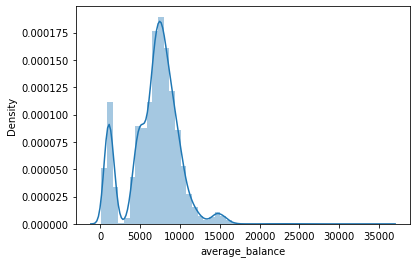

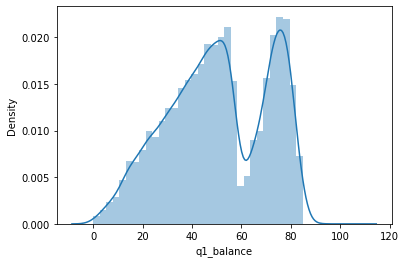

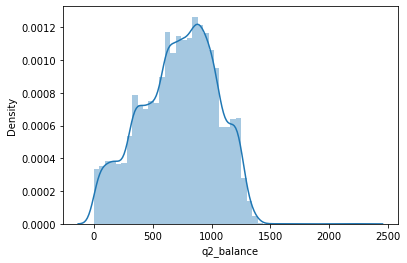

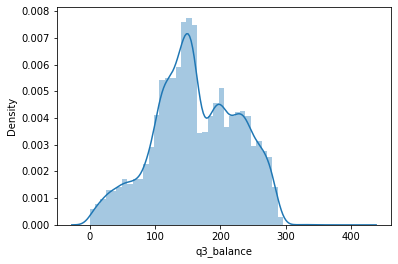

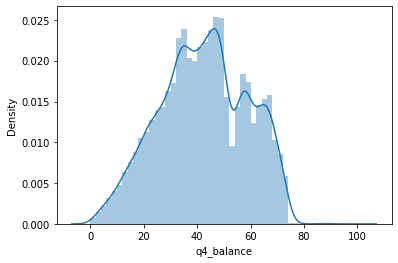

In [165]:
distribution_distplot(df)

**the boxcox transformation improves the normal distribution of the features, especially for the q2_balance and q4_balance columns.**

In [30]:
#drop the target
X = df.drop('offer_accepted', axis=1)
y = df['offer_accepted']

#### Encoding

In [31]:
X= pd.get_dummies(X)
X

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance,reward_Air Miles,...,income_level_High,income_level_Low,income_level_Medium,overdraft_protection_No,overdraft_protection_Yes,credit_rating_High,credit_rating_Low,credit_rating_Medium,own_your_home_No,own_your_home_Yes
0,1,2,1,4,8703.958501,73.836626,639.885262,173.975094,50.525011,1,...,1,0,0,1,0,1,0,0,1,0
1,1,2,2,5,563.218895,10.157140,85.875613,27.328789,30.922576,1,...,0,0,1,1,0,0,0,1,0,1
2,2,2,1,2,1299.266926,34.277501,269.331501,42.538730,25.166504,1,...,1,0,0,1,0,0,0,1,0,1
3,2,1,1,4,9287.622984,71.795308,1237.254765,176.596534,33.055723,1,...,0,0,1,1,0,1,0,0,1,0
4,1,2,1,6,9206.914353,83.588729,967.349381,161.378408,30.880781,1,...,0,0,1,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17971,1,1,1,5,668.250437,20.364395,53.691759,25.535159,32.228934,0,...,1,0,0,1,0,0,1,0,0,1
17972,1,3,1,3,5763.396657,56.640150,683.333055,156.926025,37.265522,0,...,1,0,0,1,0,0,1,0,0,1
17973,1,2,1,4,7981.026326,54.691416,563.606453,182.108919,61.203573,0,...,1,0,0,1,0,0,1,0,1,0
17974,1,4,2,2,7354.790374,45.051227,712.896118,147.842192,63.524960,0,...,0,0,1,1,0,0,0,1,0,1


#### Dealing with imbalanced data

In [32]:
# SMOTE
# Uses knn to create rows with similar features from the minority classes.

smote = SMOTE()

X_sm, y_sm = smote.fit_resample(X, y)
y_sm.value_counts()

Yes    16955
No     16955
Name: offer_accepted, dtype: int64

#### Modeling

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X_sm, y_sm, test_size=0.2, random_state=42)

**Logistic Regression**

In [56]:
def logistic_regression_model(X_train, X_test, y_train, y_test):

    # defining a function to apply the logistic regression model
    
    classification = LogisticRegression(random_state=42, max_iter=10000)
    classification.fit(X_train, y_train)
    
    # and to evaluate the model
    score = classification.score(X_test, y_test)
    print('The accuracy score is: ', score, '\n')
      
    predictions = classification.predict(X_test)
    confusion_matrix(y_test, predictions)  
   
    
    cf_matrix = confusion_matrix(y_test, predictions)
    group_names = ['True NO', 'False NO',
               'False YES', 'True YES']

    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    print (cf_matrix)
    
    

The accuracy score is:  1.0 

[[3360    0]
 [   0 2066]]


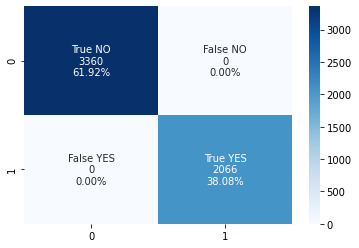

In [57]:
logistic_regression_model(X_train, X_test, y_train, y_test)

**KNN-Classifier**

In [48]:
def KNN_classifier_model(X_train, y_train, X_test, y_test,n):
    
    # define a function to apply the KNN Classifier Model
    
    knn = KNeighborsClassifier(n_neighbors=n)
    knn.fit(X_train, y_train)
    
    # and to evaluate the model
    
    print('Accuracy of K-NN classifier on test set: {:.2f}'
     .format(knn.score(X_test, y_test)))
    
    y_pred = knn.predict(X_test)
    print(confusion_matrix(y_test, y_pred))
    
    cf_matrix = confusion_matrix(y_test, y_pred)
    group_names = ['True NO', 'False NO',
               'False YES', 'True YES']

    group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    print (cf_matrix)
   

Accuracy of K-NN classifier on test set: 0.90
[[2842  518]
 [  16 2050]]
[[2842  518]
 [  16 2050]]


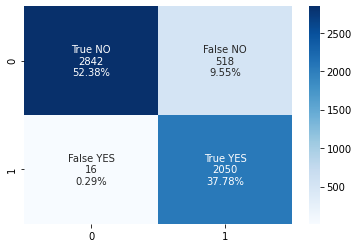

In [49]:
KNN_classifier_model(X_train,y_train,X_test,y_test,5)

In [139]:
#choose the best key value
def best_K(X_train, y_train, X_test, y_test, r):
    scores = []
    for i in r:
        model = KNeighborsClassifier(n_neighbors=i)
        model.fit(X_train, y_train)
        scores.append(model.score(X_test, y_test))
        
    plt.figure(figsize=(10,6))
    plt.plot(r,scores,color = 'blue', linestyle='dashed',
             marker='*', markerfacecolor='red', markersize=10)
    plt.title('accuracy scores vs. K Value')
    plt.xlabel('K')
    plt.ylabel('Accuracy')  

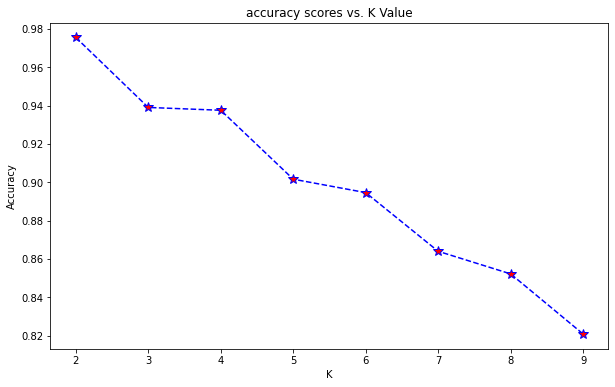

In [142]:
best_K(X_train, y_train, X_test, y_test, r=range(2,10))

### 3.2 - Preprocessing using BoxCox and UpSampling

1. Boxcox transformation on continuous variables only
2. UpSampling (60-40)
3. Encoding - get dummies
4. Modeling

In this second round, we will only change the method to deal with unbalanced data. With the SMOTE method, we are getting a dataframe with equal number of Yes and No. Here we are using the upsampling method in order to weight the target column.

#### Boxcox transformation

We are transforming only the continuous variables as previously.

In [38]:
#Boxcox function on continous variables
df1, _ci = boxcox_transform(df1)
df1

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
0,No,Air Miles,Letter,High,1,No,High,2,1,4,No,8703.958501,73.836626,639.885262,173.975094,50.525011
1,No,Air Miles,Letter,Medium,1,No,Medium,2,2,5,Yes,563.218895,10.157140,85.875613,27.328789,30.922576
2,No,Air Miles,Postcard,High,2,No,Medium,2,1,2,Yes,1299.266926,34.277501,269.331501,42.538730,25.166504
3,No,Air Miles,Letter,Medium,2,No,High,1,1,4,No,9287.622984,71.795308,1237.254765,176.596534,33.055723
4,No,Air Miles,Letter,Medium,1,No,Medium,2,1,6,Yes,9206.914353,83.588729,967.349381,161.378408,30.880781
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17971,No,Cash Back,Letter,High,1,No,Low,1,1,5,Yes,668.250437,20.364395,53.691759,25.535159,32.228934
17972,No,Cash Back,Letter,High,1,No,Low,3,1,3,Yes,5763.396657,56.640150,683.333055,156.926025,37.265522
17973,No,Cash Back,Letter,High,1,No,Low,2,1,4,No,7981.026326,54.691416,563.606453,182.108919,61.203573
17974,No,Cash Back,Letter,Medium,1,No,Medium,4,2,2,Yes,7354.790374,45.051227,712.896118,147.842192,63.524960


#### Upsampling

In [39]:
df1.offer_accepted.value_counts()

No     16955
Yes     1021
Name: offer_accepted, dtype: int64

In [40]:
# Manually
# getting sample with the 60% as the minority class
Yes = df1[df1['offer_accepted'] == 'Yes'].sample(10173, replace=True)
No = df1[df1['offer_accepted'] == 'No'].sample(16955, replace=True)

upsampled1 = pd.concat([Yes,No]).sample(frac=1) # .sample(frac=1) here is just to shuffle the dataframe
upsampled1

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
16136,No,Points,Postcard,Medium,2,No,Low,1,1,5,Yes,9576.544607,31.883281,972.746186,236.998440,63.072159
13090,No,Cash Back,Letter,Medium,1,No,Low,3,1,4,No,6982.818464,73.036079,814.128073,144.638149,29.377139
4729,Yes,Air Miles,Postcard,Medium,1,No,Medium,2,2,5,No,6409.693384,41.981456,354.324318,196.139816,58.676019
13088,Yes,Points,Letter,Medium,1,No,Low,2,1,3,Yes,11508.355190,84.093188,1079.662964,162.624044,51.652718
16666,No,Points,Letter,Medium,1,No,Medium,1,1,4,Yes,9510.459194,50.467193,825.027046,259.077114,52.428348
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6440,Yes,Air Miles,Letter,Medium,1,No,Low,3,1,1,No,4593.835315,42.372576,673.692101,119.645896,43.896767
9246,No,Cash Back,Postcard,High,1,No,Medium,2,1,5,Yes,1154.884936,30.182624,173.069390,45.200594,30.074656
9112,Yes,Points,Letter,Low,1,No,Low,1,1,4,Yes,9028.462123,72.901776,1166.624600,110.510378,48.588801
2171,No,Air Miles,Postcard,Medium,1,No,Low,3,2,3,Yes,6223.650470,72.901776,812.083583,137.764632,13.142468


In [42]:
upsampled1.offer_accepted.value_counts()

No     16955
Yes    10173
Name: offer_accepted, dtype: int64

#### Encoding

In [43]:
X1 = upsampled1.drop('offer_accepted', axis=1)
y1 = upsampled1['offer_accepted']

In [44]:
X1 = pd.get_dummies(upsampled1)
X1

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance,offer_accepted_No,...,income_level_High,income_level_Low,income_level_Medium,overdraft_protection_No,overdraft_protection_Yes,credit_rating_High,credit_rating_Low,credit_rating_Medium,own_your_home_No,own_your_home_Yes
16136,2,1,1,5,9576.544607,31.883281,972.746186,236.998440,63.072159,1,...,0,0,1,1,0,0,1,0,0,1
13090,1,3,1,4,6982.818464,73.036079,814.128073,144.638149,29.377139,1,...,0,0,1,1,0,0,1,0,1,0
4729,1,2,2,5,6409.693384,41.981456,354.324318,196.139816,58.676019,0,...,0,0,1,1,0,0,0,1,1,0
13088,1,2,1,3,11508.355190,84.093188,1079.662964,162.624044,51.652718,0,...,0,0,1,1,0,0,1,0,0,1
16666,1,1,1,4,9510.459194,50.467193,825.027046,259.077114,52.428348,1,...,0,0,1,1,0,0,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6440,1,3,1,1,4593.835315,42.372576,673.692101,119.645896,43.896767,0,...,0,0,1,1,0,0,1,0,1,0
9246,1,2,1,5,1154.884936,30.182624,173.069390,45.200594,30.074656,1,...,1,0,0,1,0,0,0,1,0,1
9112,1,1,1,4,9028.462123,72.901776,1166.624600,110.510378,48.588801,0,...,0,1,0,1,0,0,1,0,0,1
2171,1,3,2,3,6223.650470,72.901776,812.083583,137.764632,13.142468,1,...,0,0,1,1,0,0,1,0,0,1


#### Modeling

**Logistic Regression**

In [59]:
 X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.2, random_state=42)

The accuracy score is:  1.0 

[[3360    0]
 [   0 2066]]


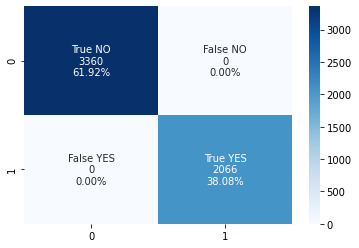

In [60]:
logistic_regression_model(X1_train, X1_test, y1_train, y1_test)

**KNN Classifier**

Accuracy of K-NN classifier on test set: 0.90
[[2842  518]
 [  16 2050]]
[[2842  518]
 [  16 2050]]


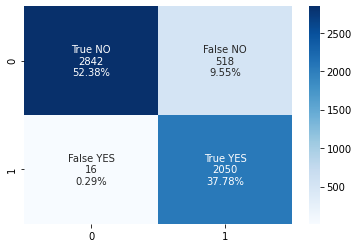

In [61]:
KNN_classifier_model(X1_train,y1_train,X1_test,y1_test,5)

### 3.3 - Preprocessing using Upsampling and normalization

1. Numerical columns in a list
2. Dealing with imbalanced - UpSampling
3. Encoding - get dummies
4. train-test split
5. Normalization of the numerical columns
6. Modeling

In [62]:
numerical = df2.select_dtypes(np.number)

numerical.columns

Index(['bank_accounts_open', 'credit_cards_held', 'homes_owned',
       'household_size', 'average_balance', 'q1_balance', 'q2_balance',
       'q3_balance', 'q4_balance'],
      dtype='object')

In [63]:
num_col = ['bank_accounts_open', 'credit_cards_held', 'homes_owned',
       'household_size', 'average_balance','q1_balance', 'q2_balance', 'q3_balance',
       'q4_balance']

#### Upsampling

In [64]:
df2['offer_accepted'].value_counts()

No     16955
Yes     1021
Name: offer_accepted, dtype: int64

In [65]:
# Manually
# getting sample with the 60% as the minority class
Yes = df2[df2['offer_accepted'] == 'Yes'].sample(10173, replace=True)
No = df2[df2['offer_accepted'] == 'No'].sample(16955, replace=True)

upsampled2 = pd.concat([Yes,No]).sample(frac=1) # .sample(frac=1) here is just to shuffle the dataframe
upsampled2

,offer_accepted,reward,mailer_type,income_level,bank_accounts_open,overdraft_protection,credit_rating,credit_cards_held,homes_owned,household_size,own_your_home,average_balance,q1_balance,q2_balance,q3_balance,q4_balance
16691,No,Points,Letter,Medium,2,No,High,2,1,3,Yes,1015.25,848.0,585.0,2001.0,627.0
17485,No,Cash Back,Letter,Medium,1,Yes,Medium,1,1,3,Yes,1313.50,583.0,1126.0,2269.0,1276.0
3367,No,Air Miles,Postcard,High,2,No,High,2,1,1,Yes,641.25,644.0,750.0,647.0,524.0
11537,No,Points,Postcard,High,1,No,Low,1,2,1,Yes,800.75,270.0,1139.0,1365.0,429.0
9358,No,Points,Letter,Medium,1,No,High,3,2,3,Yes,751.50,730.0,648.0,812.0,816.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12569,No,Air Miles,Postcard,Medium,1,No,High,2,1,4,Yes,1211.00,1709.0,1030.0,1319.0,786.0
16330,No,Cash Back,Letter,Medium,1,No,High,3,1,5,Yes,720.25,907.0,805.0,574.0,595.0
11843,No,Points,Postcard,Medium,1,No,Medium,1,1,3,Yes,1265.50,1937.0,1382.0,1158.0,585.0
14067,Yes,Points,Letter,Medium,1,No,High,2,1,3,Yes,866.00,1699.0,1040.0,666.0,59.0


#### Encoding

In [66]:
X2 = upsampled2.drop('offer_accepted', axis=1)
y2 = upsampled2['offer_accepted']

In [67]:
X2 = pd.get_dummies(upsampled2)
X2

,bank_accounts_open,credit_cards_held,homes_owned,household_size,average_balance,q1_balance,q2_balance,q3_balance,q4_balance,offer_accepted_No,...,income_level_High,income_level_Low,income_level_Medium,overdraft_protection_No,overdraft_protection_Yes,credit_rating_High,credit_rating_Low,credit_rating_Medium,own_your_home_No,own_your_home_Yes
16691,2,2,1,3,1015.25,848.0,585.0,2001.0,627.0,1,...,0,0,1,1,0,1,0,0,0,1
17485,1,1,1,3,1313.50,583.0,1126.0,2269.0,1276.0,1,...,0,0,1,0,1,0,0,1,0,1
3367,2,2,1,1,641.25,644.0,750.0,647.0,524.0,1,...,1,0,0,1,0,1,0,0,0,1
11537,1,1,2,1,800.75,270.0,1139.0,1365.0,429.0,1,...,1,0,0,1,0,0,1,0,0,1
9358,1,3,2,3,751.50,730.0,648.0,812.0,816.0,1,...,0,0,1,1,0,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12569,1,2,1,4,1211.00,1709.0,1030.0,1319.0,786.0,1,...,0,0,1,1,0,1,0,0,0,1
16330,1,3,1,5,720.25,907.0,805.0,574.0,595.0,1,...,0,0,1,1,0,1,0,0,0,1
11843,1,1,1,3,1265.50,1937.0,1382.0,1158.0,585.0,1,...,0,0,1,1,0,0,0,1,0,1
14067,1,2,1,3,866.00,1699.0,1040.0,666.0,59.0,0,...,0,0,1,1,0,1,0,0,0,1


#### Normalizing

We are normalizing the numerical variables that is to say that we will exclude the encoded categorical variables.

Therefore, we will create the X dataframes on which to apply the normalization and then concatenate them to get the final dataframe on which the model will be trained.

In [68]:
# train-test split

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state=0)

In [69]:
#normalizing training and testing set only on numerical variables and not the original categorical variables

X_train_n = X2_train.filter(['bank_accounts_open', 'credit_cards_held', 'homes_owned',
       'household_size', 'average_balance','q1_balance', 'q2_balance', 'q3_balance',
       'q4_balance'], axis = 1)

X_test_n = X2_test.filter(['bank_accounts_open', 'credit_cards_held', 'homes_owned',
       'household_size', 'average_balance','q1_balance', 'q2_balance', 'q3_balance',
       'q4_balance'], axis = 1)

In [70]:
#normalization

transformer = Normalizer()
transformer.fit(X_train_n)

# saving in a pickle
with open('std_transformer.pickle', 'wb') as file:
    pickle.dump(transformer, file)
    
# loading from a pickle  
with open('std_transformer.pickle', 'rb') as file:
    loaded_normalizer = pickle.load(file)

X_train_ = loaded_normalizer.transform(X_train_n)
X_test_ = loaded_normalizer.transform(X_test_n)

In [ ]:
#Getting the final dataframe with the normalized variables and the encoded variables.

In [71]:
num_train = pd.DataFrame(X_train_, columns = num_col)
num_test = pd.DataFrame(X_test_, columns = num_col)

In [72]:
X2_train.columns

Index(['bank_accounts_open', 'credit_cards_held', 'homes_owned',
       'household_size', 'average_balance', 'q1_balance', 'q2_balance',
       'q3_balance', 'q4_balance', 'offer_accepted_No', 'offer_accepted_Yes',
       'reward_Air Miles', 'reward_Cash Back', 'reward_Points',
       'mailer_type_Letter', 'mailer_type_Postcard', 'income_level_High',
       'income_level_Low', 'income_level_Medium', 'overdraft_protection_No',
       'overdraft_protection_Yes', 'credit_rating_High', 'credit_rating_Low',
       'credit_rating_Medium', 'own_your_home_No', 'own_your_home_Yes'],
      dtype='object')

In [78]:
X_train_c = X2_train.filter(['reward_Air Miles', 'reward_Cash Back', 'reward_Points',
       'mailer_type_Letter', 'mailer_type_Postcard', 'income_level_High',
       'income_level_Low', 'income_level_Medium', 'overdraft_protection_No',
       'overdraft_protection_Yes', 'credit_rating_High', 'credit_rating_Low',
       'credit_rating_Medium', 'own_your_home_No', 'own_your_home_Yes'], axis = 1)

In [79]:
X_train_final= pd.concat([num_train.reset_index(drop=True), X_train_c.reset_index(drop=True)], axis=1, ignore_index=True)

X_train_final.info() #checking NAN values


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20346 entries, 0 to 20345
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       20346 non-null  float64
 1   1       20346 non-null  float64
 2   2       20346 non-null  float64
 3   3       20346 non-null  float64
 4   4       20346 non-null  float64
 5   5       20346 non-null  float64
 6   6       20346 non-null  float64
 7   7       20346 non-null  float64
 8   8       20346 non-null  float64
 9   9       20346 non-null  uint8  
 10  10      20346 non-null  uint8  
 11  11      20346 non-null  uint8  
 12  12      20346 non-null  uint8  
 13  13      20346 non-null  uint8  
 14  14      20346 non-null  uint8  
 15  15      20346 non-null  uint8  
 16  16      20346 non-null  uint8  
 17  17      20346 non-null  uint8  
 18  18      20346 non-null  uint8  
 19  19      20346 non-null  uint8  
 20  20      20346 non-null  uint8  
 21  21      20346 non-null  uint8  
 22

In [80]:
X_test_c = X2_test.filter(['reward_Air Miles', 'reward_Cash Back', 'reward_Points',
       'mailer_type_Letter', 'mailer_type_Postcard', 'income_level_High',
       'income_level_Low', 'income_level_Medium', 'overdraft_protection_No',
       'overdraft_protection_Yes', 'credit_rating_High', 'credit_rating_Low',
       'credit_rating_Medium', 'own_your_home_No', 'own_your_home_Yes'], axis = 1)

In [82]:
X_test_final= pd.concat([num_test.reset_index(drop=True), X_test_c.reset_index(drop=True)], axis=1, ignore_index=True)

X_test_final.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6782 entries, 0 to 6781
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   0       6782 non-null   float64
 1   1       6782 non-null   float64
 2   2       6782 non-null   float64
 3   3       6782 non-null   float64
 4   4       6782 non-null   float64
 5   5       6782 non-null   float64
 6   6       6782 non-null   float64
 7   7       6782 non-null   float64
 8   8       6782 non-null   float64
 9   9       6782 non-null   uint8  
 10  10      6782 non-null   uint8  
 11  11      6782 non-null   uint8  
 12  12      6782 non-null   uint8  
 13  13      6782 non-null   uint8  
 14  14      6782 non-null   uint8  
 15  15      6782 non-null   uint8  
 16  16      6782 non-null   uint8  
 17  17      6782 non-null   uint8  
 18  18      6782 non-null   uint8  
 19  19      6782 non-null   uint8  
 20  20      6782 non-null   uint8  
 21  21      6782 non-null   uint8  
 22  

#### Modeling

**Logistic Regression**

The accuracy score is:  0.694337953406075 

[[3515  702]
 [1371 1194]]


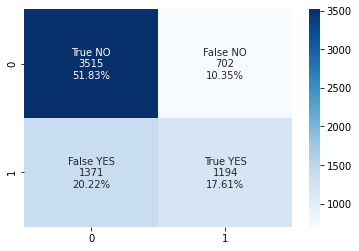

In [83]:
logistic_regression_model(X_train_final, X_test_final, y2_train, y2_test)

**KNN Classifier**

Accuracy of K-NN classifier on test set: 0.90
[[3596  621]
 [  43 2522]]
[[3596  621]
 [  43 2522]]


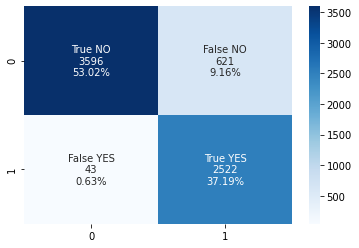

In [85]:
KNN_classifier_model(X_train_final,y2_train,X_test_final,y2_test,5)

## Conclusion